In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from itertools import combinations
import pandas as pd
import glob

# Mutation accumulation experiment

Mutation-accumulation (MA) experiment is used to experimentally measure the mutation rate. Fifty lines of an E. coli B strain were isolated by picking a single colony (the founder colony) from an agar plate, streaking onto a new plate, incubating overnight at 37 °C, then repeating the pick-streak-incubate procedure (called a growth cycle, GC) for 50 of the resultant colonies. These 50 lines were grown under identical conditions for 300 growth cycles. All fifty lines were derived from a single cell (the founding cell of the founder colony), and were genetically identical except for the mutations that might have occurred during colony expansion (growth
cycle 0). Throughout the mutation accumulation phase, there were ~25 rounds of cell division per growth cycle. Thus each line experienced 300 single cell bottlenecks and ~7,500 rounds of cell division. At growth cycles
0, 100, 120, 200, 250 and 300, sub-samples of each line were frozen in a glycerol-based suspension at -80 °C. These frozen samples were stored for use in fitness assays.

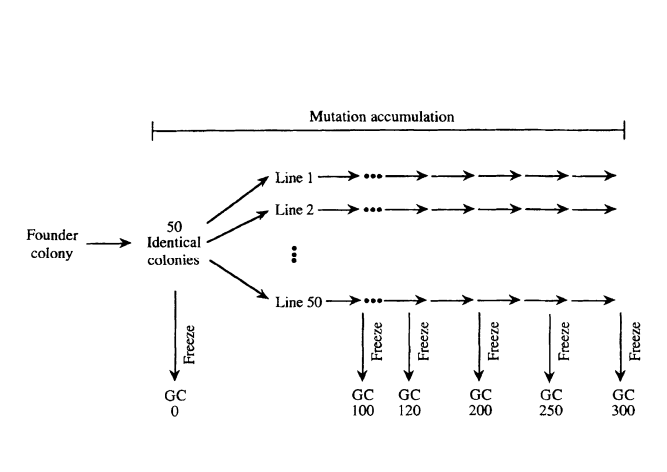

They estimate the mutation rate from the mathematical dependence between the relative fitness and time (circles on a plot below) and between among-line variance in fitness and time (squares on a plot below) 

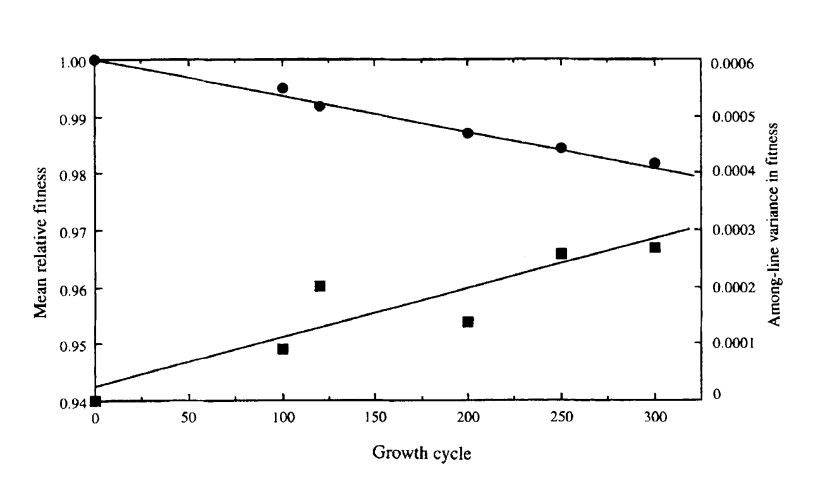

The following is a simulation of MA-experiment

In [3]:
class experiment():
    
    def __init__(self, mu=1e-4, s=0.01, mu1=None, mu2=None, s1=None, s2=None): 
        #selection coefficient
        self.s = s
        #mutation rate
        self.mu = mu
        #here we start from the population of a single individual
        #we describe each genotype simply by number of mutations relative to "wild-type" (wild-type=0)
        #hence, effectively, the genome has an infinite length
        self.genotypes = np.zeros(1) 
        #later we want to track fitness, population size and genotype frequencies through growth cycles
        self.gc_fitness = []
        self.pop_size = []
        self.genotypes_history = []
        self.genotypes_freq = []
        #we can run simulations in mut_partitions_mode when mu is different along the genome
        #another option is selection_partitions_mode when selection coefficient is not constant along the genome  
        self.mut_partitions_mode = False
        self.selection_partitions_mode = False
        
        self.genotypes_history_part1 = []
        self.genotypes_history_part2 = []
        self.genotypes_freq_part1 = []
        self.genotypes_freq_part2 = []
        
        if (mu1 is not None) and (mu2 is not None):
            self.mut_partitions_mode = True
            self.mu1 = mu1
            self.mu2 = mu2
            #now genotypes are described by two numbers: number of mutations in each part of a genome
            self.genotypes_part1 = np.zeros(1)
            self.genotypes_part2 = np.zeros(1)
            
        if (s1 is not None) and (s2 is not None):
            self.selection_partitions_mode = True
            self.s1 = s1
            self.s2 = s2
            #now genotypes are described by two numbers: number of mutations in each part of a genome
            self.genotypes_part1 = np.zeros(1)
            self.genotypes_part2 = np.zeros(1)

        #we calculate initial fitness of genotypes
        self.calculate_fitness()
    
    def calculate_fitness(self):
        if not self.selection_partitions_mode:
            #we assume here that all mutations are equally deleterious and independent
            #all mutations reduce fitness by s (i.e. fitness of a genotype with n mutations is (1-s)**n)
            self.fitness = (1 - self.s)**self.genotypes
        else:
            #mutations have different effects in different parts of a genome
            #these effects are described by selection coefficients s1 and s2
            self.fitness = ((1 - self.s1)**self.genotypes_part1) * ((1 - self.s2)**self.genotypes_part2)
        
    def mutation_process(self):
        if self.selection_partitions_mode or self.mut_partitions_mode:
            #we need to mutate two parts of a genome separately
            #mutations arise according to Poisson process with mean=mu
            if self.mut_partitions_mode:
                mutations_part1 = np.random.poisson(self.mu1/2, len(self.genotypes))
                mutations_part2 = np.random.poisson(self.mu2/2, len(self.genotypes))
            else:
                mutations_part1 = np.random.poisson(self.mu/2, len(self.genotypes))
                mutations_part2 = np.random.poisson(self.mu/2, len(self.genotypes))
            #we describe genotypes of two parts separately and together (in self.genotypes we don't distinguish)
            self.genotypes_part1 += mutations_part1
            self.genotypes_part2 += mutations_part2
            self.genotypes += mutations_part1
            self.genotypes += mutations_part2
        else:
            #genome is homogeneous
            mutations = np.random.poisson(self.mu, len(self.genotypes))
            self.genotypes += mutations
    
    def growth_process(self):
        #here we implement the growth of the population
        #we define all genotypes in a population and their counts
        #we make them reproduce according to their fitness
        #population is described with loistic growth, the carrying capacity of the environment is K
        K = 10000
        new_genotypes = []
        if self.selection_partitions_mode or self.mut_partitions_mode:
            genome = np.vstack([self.genotypes_part1, self.genotypes_part2])
            genotypes, idx, counts = np.unique(genome, axis=1, return_counts=True, return_index=True)
            for genotype, index, count in zip(genotypes.T, idx, counts):
                growth_rate = self.fitness[index]
                n_offspring = growth_rate * count * (1 - len(self.genotypes)/K)
                new_genotypes.append(np.tile(genotype, [round(count + n_offspring), 1]))
            self.genotypes = np.vstack(new_genotypes).sum(axis=1)
            self.genotypes_part1 = np.vstack(new_genotypes)[:, 0]
            self.genotypes_part2 = np.vstack(new_genotypes)[:, 1]
        else:
            genotypes, idx, counts = np.unique(self.genotypes, return_counts=True, return_index=True)
            for genotype, index, count in zip(genotypes, idx, counts):
                growth_rate = self.fitness[index]
                n_offspring = growth_rate * count * (1 - len(self.genotypes)/K)
                new_genotypes.append(np.repeat(genotype, round(count + n_offspring)))
            self.genotypes = np.hstack(new_genotypes)
                    
    def generation(self):
        #At each generation our population goes through mutation and growth
        #mutation (at this stage each genotype can gain a mutation)
        self.mutation_process()
        #we re-calculate fitness for mutants
        self.calculate_fitness()
        #population grows (reproduction stage)
        self.growth_process()

    def evolve(self, nGrowthCyc=300, nDivPerCyc=25):
        for gc in range(nGrowthCyc):
            #we pick up a founder cell (one random individual from a population)
            if gc >= 1:
                random_idx = np.random.choice(len(self.genotypes), 1)
                self.genotypes = self.genotypes[random_idx]
                if self.selection_partitions_mode or self.mut_partitions_mode:
                    self.genotypes_part1 = self.genotypes_part1[random_idx]
                    self.genotypes_part2 = self.genotypes_part2[random_idx]
                self.calculate_fitness()
            #growth phase (we put the selected cell on a plate and let it grow for nDivPerCyc generations)
            #on each step we save all intersting parameters
            for i in range(nDivPerCyc):
                self.generation()
                self.pop_size.append(len(self.genotypes))
                self.genotypes_history.append(self.genotypes.mean())
                self.genotypes_freq.append((gc, i, np.unique(self.genotypes, return_counts=True)[0],
                                           np.unique(self.genotypes, return_counts=True)[1]))
                if self.selection_partitions_mode or self.mut_partitions_mode:
                    self.genotypes_history_part1.append(self.genotypes_part1.mean())
                    self.genotypes_history_part2.append(self.genotypes_part2.mean())
                    self.genotypes_freq_part1.append(np.unique(self.genotypes_part1, return_counts=True))
                    self.genotypes_freq_part2.append(np.unique(self.genotypes_part2, return_counts=True))
            self.gc_fitness.append(self.fitness.mean())

Below is the code to run the model with different parameters, build pictures etc.

# The baseline experiment

In [37]:
#How many times we will repeat the experiment (50 lines in the original paper)
nLines = 50
#Number of growth cycles (300 cycles in the original paper)
nGrowthCyc = 300
#Number of cell divisions per cycle (25 in the original paper)
nDivPerCyc = 25

In [131]:
mu = 1e-4
s = 0.01

In [142]:
%%time
experiment_results = []
average_muts = []
mut_freq = []
#we run a separate experiment for each line and remember the fitness measurements
for line in tqdm(range(nLines)):
    exp = experiment(mu=mu, s=s)
    exp.evolve(nGrowthCyc=300, nDivPerCyc=nDivPerCyc)
    #we save fitness measurements for each line at each growth cycle
    experiment_results.append(exp.gc_fitness)
    #save genotypes numbers
    #line_genotypes[line] = exp.genotypes_history
    average_muts.append(exp.genotypes_history)
    mut_freq.append(exp.genotypes_freq)
experiment_results = np.array(experiment_results)
average_muts = np.array(average_muts)


Wall time: 4min 13s


In [253]:
#We have a matrix of shape (number of lines x number of growth cycles)
experiment_results.shape, average_muts.shape

((50, 300), (50, 7500))

Text(0, 0.5, 'Mean relative fitness')

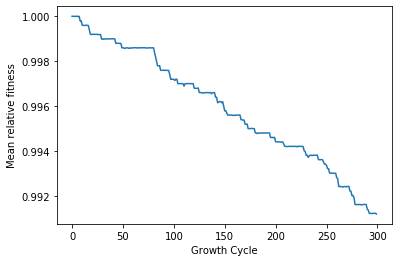

In [6]:
#Mean fitness among lines per growth cycle
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results.mean(axis=0))
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')

In [394]:
model = LinearRegression()
x = np.arange(nGrowthCyc)
y = experiment_results.mean(axis=0)
model.fit(x.reshape(-1, 1), y)
R = model.coef_
model.intercept_ , model.coef_

(0.9993346461093875, array([-2.19763641e-05]))

Text(0, 0.5, 'Mean relative fitness')

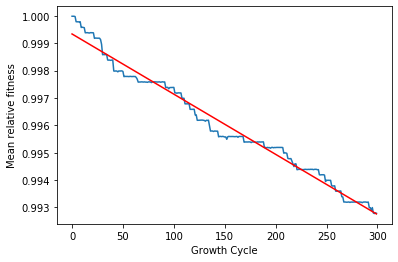

In [395]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results.mean(axis=0))
plt.plot(x, (model.intercept_ + model.coef_*x).flatten(), color='red')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')

Text(0, 0.5, 'Among-line variance in fitness')

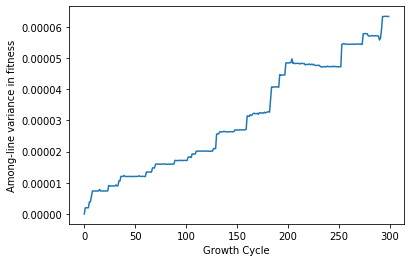

In [211]:
#Variance in fitness among lines per growth cycle
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results.std(axis=0)**2)
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')

In [212]:
model = LinearRegression()
x = np.arange(nGrowthCyc)
y = experiment_results.std(axis=0)**2
model.fit(x.reshape(-1, 1), y)
V = model.coef_
model.intercept_ , model.coef_

(8.443040326853741e-07, array([2.00228001e-07]))

Text(0, 0.5, 'Among-line variance in fitness')

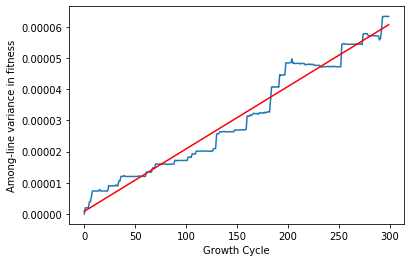

In [190]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results.std(axis=0)**2)
plt.plot(x, (model.intercept_ + model.coef_*x).flatten(), color='red')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')

In [256]:
average_muts.mean(axis=0).shape

(7500,)

Text(0, 0.5, 'Average number of mutations in a genome (among lines)')

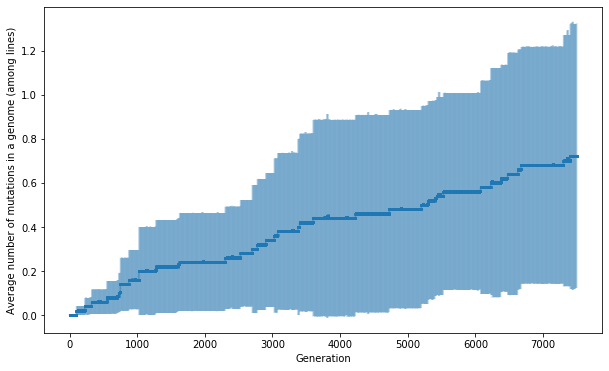

In [266]:
#Average number of mutations in a genome
fig, ax = plt.subplots(figsize=(10, 6))
plt.errorbar(x=np.arange(average_muts.shape[1]), y=average_muts.mean(axis=0), 
             yerr=average_muts.std(axis=0)**2, alpha=0.5, marker='s', ms=2, elinewidth=0.1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations in a genome (among lines)')

In [259]:
#Estimate of mutation rate from a plot
0.7/7500

9.333333333333333e-05

In [267]:
#estimates of mutation rate and selection (formulae from the paper)
(R**2)/V, V/R

(array([0.00286997]), array([-0.00835264]))

In [268]:
#True values
exp.mu, exp.s

(0.0001, 0.01)

In [269]:
#Raw coefficients (R is supposed to be U*<s>, V is supposed to be U*var(<s^2>))
R, V

(array([-2.39718335e-05]), array([2.00228001e-07]))

In [ ]:
#run with different parameters
for mu in [0.01, 0.001, 0.0001]:
    for s in [0.1, 0.01, 0.001]:
        experiment_results = []
        average_muts = []
        #we run a separate experiment for each line and remember the fitness measurements
        for line in tqdm(range(nLines)):
            exp = experiment(mu=mu, s=s)
            exp.evolve(nGrowthCyc=300, nDivPerCyc=nDivPerCyc)
            #we save fitness measurements for each line at each growth cycle
            experiment_results.append(exp.gc_fitness)
            #save genotypes numbers
            #line_genotypes[line] = exp.genotypes_history
            average_muts.append(exp.genotypes_history)
        experiment_results = np.array(experiment_results)
        average_muts = np.array(average_muts)
        np.save(f'data/baseline_experiment_mu_{mu}_s_{s}.npy', experiment_results)
        np.save(f'data/baseline_experiment_mut_counts_mu_{mu}_s_{s}.npy', average_muts)

# Different mutation rates along the genome 

Here we assume that in our experiment different parts of a genome mutate with different rates (we consider two parts with mutation rate mu1 and mu2)

In [15]:
#a function to easily calculate the regression coefficient for our calculations
def calculate_regression_coefficient(x, y):
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    return model.coef_

In [4]:
s=0.01
mu1=1e-4
mu2=1e-2

In [5]:
#How many times we will repeat the experiment (50 lines in the original paper)
nLines = 1
#Number of growth cycles (300 cycles in the original paper)
nGrowthCyc = 100
#Number of cell divisions per cycle (25 in the original paper)
nDivPerCyc = 25

In [15]:
%%time
mut_parts_experiment_results = []
mut_parts_average_muts = []
average_muts_part1 = []
average_muts_part2 = []

#we run a separate experiment for each line and remember the fitness measurements
for line in tqdm(range(nLines)):
    exp = experiment(s=s, mu1=mu1, mu2=mu2)
    exp.evolve(nGrowthCyc=300, nDivPerCyc=nDivPerCyc)
    #we save fitness measurements for each line at each growth cycle
    mut_parts_experiment_results.append(exp.gc_fitness)
    #save mutation numbers
    mut_parts_average_muts.append(exp.genotypes_history)
    #save mutation numbers for partitions separately
    average_muts_part1.append(exp.genotypes_history_part1)
    average_muts_part2.append(exp.genotypes_history_part2)

mut_parts_experiment_results = np.array(mut_parts_experiment_results)
mut_parts_average_muts = np.array(mut_parts_average_muts)
average_muts_part1 = np.array(average_muts_part1)
average_muts_part2 = np.array(average_muts_part2)


Wall time: 14min 49s


In [16]:
np.save(f'data/different_mus_experiment_mu1{mu1}_mu2{mu2}.npy', mut_parts_experiment_results)
np.save(f'data/different_mus_experiment_mut_counts_mu1{mu1}_mu2{mu2}.npy', mut_parts_average_muts)
np.save(f'data/different_mus_experiment_mut_counts_part1_mu1{mu1}_mu2{mu2}.npy', average_muts_part1)
np.save(f'data/different_mus_experiment_mut_counts_part2_mu1{mu1}_mu2{mu2}.npy', average_muts_part2)

Text(0, 0.5, 'Mean relative fitness')

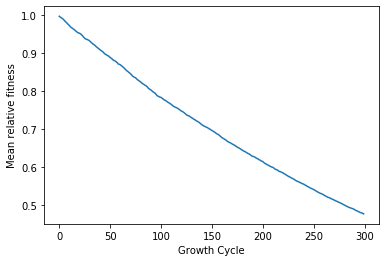

In [362]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results.mean(axis=0))
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')

In [363]:
R = calculate_regression_coefficient(np.arange(nGrowthCyc), mut_parts_experiment_results.mean(axis=0))
R

array([-0.00173886])

Text(0, 0.5, 'Among-line variance in fitness')

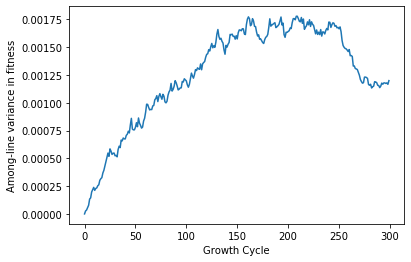

In [364]:
#Variance in fitness among lines per growth cycle
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results.std(axis=0)**2)
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')

In [365]:
V = calculate_regression_coefficient(np.arange(nGrowthCyc), mut_parts_experiment_results.std(axis=0)**2)
V

array([3.66329427e-06])

Text(0, 0.5, 'Average number of mutations in a genome (among lines)')

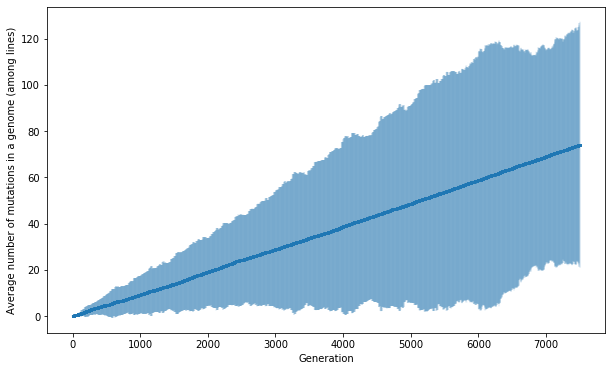

In [366]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.errorbar(x=np.arange(mut_parts_average_muts.shape[1]), y=mut_parts_average_muts.mean(axis=0), 
             yerr=mut_parts_average_muts.std(axis=0)**2, alpha=0.5, marker='s', ms=2, elinewidth=0.1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations in a genome (among lines)')

In [367]:
70/7500

0.009333333333333334

In [281]:
(R**2)/V, V/R

(array([0.85180577]), array([-0.00207862]))

Text(0, 0.5, 'Average number of mutations in a genome (among lines)')

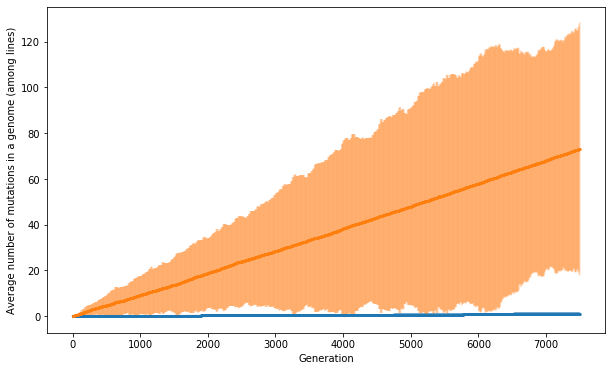

In [369]:
#The same plot for ywo parts of the genome separately
fig, ax = plt.subplots(figsize=(10, 6))
plt.errorbar(x=np.arange(average_muts_part1.shape[1]), y=average_muts_part1.mean(axis=0), 
             yerr=average_muts_part1.std(axis=0)**2, alpha=0.5, marker='s', ms=1, elinewidth=0.1)
plt.errorbar(x=np.arange(average_muts_part2.shape[1]), y=average_muts_part2.mean(axis=0), 
             yerr=average_muts_part2.std(axis=0)**2, alpha=0.5, marker='s', ms=1, elinewidth=0.1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations in a genome (among lines)')

In [ ]:
#run with different parameters
s = 0.01
for mu1, mu2 in combinations([0.01, 0.001, 0.0001], 2):
    mut_parts_experiment_results = []
    mut_parts_average_muts = []
    average_muts_part1 = []
    average_muts_part2 = []
    
    #we run a separate experiment for each line and remember the fitness measurements
    for line in tqdm(range(nLines)):
        exp = experiment(s=s, mu1=mu1, mu2=mu2)
        exp.evolve(nGrowthCyc=300, nDivPerCyc=nDivPerCyc)
        #we save fitness measurements for each line at each growth cycle
        mut_parts_experiment_results.append(exp.gc_fitness)
        #save mutation numbers
        mut_parts_average_muts.append(exp.genotypes_history)
        #save mutation numbers for partitions separately
        average_muts_part1.append(exp.genotypes_history_part1)
        average_muts_part2.append(exp.genotypes_history_part2)

    mut_parts_experiment_results = np.array(mut_parts_experiment_results)
    mut_parts_average_muts = np.array(mut_parts_average_muts)
    average_muts_part1 = np.array(average_muts_part1)
    average_muts_part2 = np.array(average_muts_part2)
    
    np.save(f'clean_data/different_mus_experiment_mu1_{mu1}_mu2_{mu2}_s_{s}.npy', mut_parts_experiment_results)
    np.save(f'clean_data/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}.npy', mut_parts_average_muts)
    np.save(f'clean_data/different_mus_experiment_mut_counts_part1_mu1_{mu1}_mu2_{mu2}_s_{s}.npy', average_muts_part1)
    np.save(f'clean_data/different_mus_experiment_mut_counts_part2_mu1_{mu1}_mu2_{mu2}_s_{s}.npy', average_muts_part2)


# Different selection coefficients along the genome

Here we assume that in our experiment mutations in different parts of a genome have different selection coefficients (we consider two parts with selection coefficients s1 and s2)

In [17]:
mu=1e-4
s1=0.001
s2=0.01

In [18]:
%%time
sel_parts_experiment_results = []
sel_parts_average_muts = []
average_muts_part1_s1 = []
average_muts_part2_s2 = []

#we run a separate experiment for each line and remember the fitness measurements
for line in tqdm(range(nLines)):
    exp = experiment(mu=mu, s1=s1, s2=s2)
    exp.evolve(nGrowthCyc=300, nDivPerCyc=nDivPerCyc)
    #we save fitness measurements for each line at each growth cycle
    sel_parts_experiment_results.append(exp.gc_fitness)
    #save mutation numbers
    sel_parts_average_muts.append(exp.genotypes_history)
    #save mutation numbers for partitions separately
    average_muts_part1_s1.append(exp.genotypes_history_part1)
    average_muts_part2_s2.append(exp.genotypes_history_part2)

sel_parts_experiment_results = np.array(sel_parts_experiment_results)
sel_parts_average_muts = np.array(sel_parts_average_muts)
average_muts_part1_s1 = np.array(average_muts_part1_s1)
average_muts_part2_s2 = np.array(average_muts_part2_s2)


Wall time: 12min 31s


In [19]:
np.save(f'data/different_s_experiment_s1{s1}_s2{s2}.npy', sel_parts_experiment_results)
np.save(f'data/different_s_experiment_mut_counts_s1{s1}_s2{s2}.npy', sel_parts_average_muts)
np.save(f'data/different_s_experiment_mut_counts_part1_s1{s1}_s2{s2}.npy', average_muts_part1_s1)
np.save(f'data/different_s_experiment_mut_counts_part2_s1{s1}_s2{s2}.npy', average_muts_part2_s2)

Text(0, 0.5, 'Mean relative fitness')

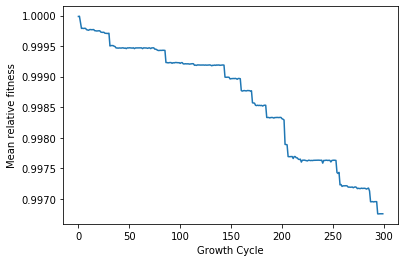

In [384]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), sel_parts_experiment_results.mean(axis=0))
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')

In [385]:
R = calculate_regression_coefficient(np.arange(nGrowthCyc), sel_parts_experiment_results.mean(axis=0))
R

array([-1.0366452e-05])

Text(0, 0.5, 'Among-line variance in fitness')

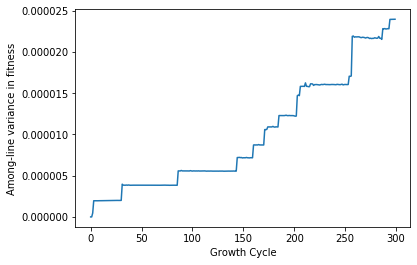

In [386]:
#Variance in fitness among lines per growth cycle
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), sel_parts_experiment_results.std(axis=0)**2)
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')

In [387]:
V = calculate_regression_coefficient(np.arange(nGrowthCyc), sel_parts_experiment_results.std(axis=0)**2)
V

array([7.56199902e-08])

In [388]:
(R**2)/V, V/R

(array([0.0014211]), array([-0.00729468]))

Text(0, 0.5, 'Average number of mutations in a genome (among lines)')

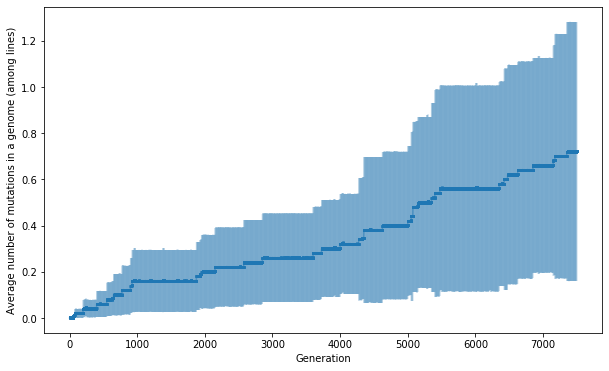

In [389]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.errorbar(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), 
             yerr=sel_parts_average_muts.std(axis=0)**2, alpha=0.5, marker='s', ms=2, elinewidth=0.1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations in a genome (among lines)')

Text(0, 0.5, 'Average number of mutations in a genome (among lines)')

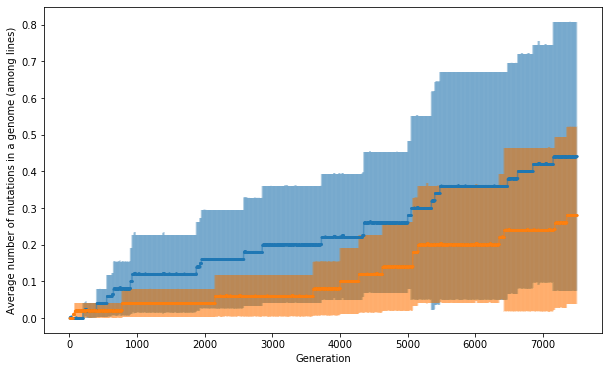

In [391]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.errorbar(x=np.arange(average_muts_part1_s1.shape[1]), y=average_muts_part1_s1.mean(axis=0), 
             yerr=average_muts_part1_s1.std(axis=0)**2, alpha=0.5, marker='s', ms=1, elinewidth=0.1)
plt.errorbar(x=np.arange(average_muts_part2_s2.shape[1]), y=average_muts_part2_s2.mean(axis=0), 
             yerr=average_muts_part2_s2.std(axis=0)**2, alpha=0.5, marker='s', ms=1, elinewidth=0.1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations in a genome (among lines)')

In [ ]:
#run with different parameters
mu = 0.01
for s1, s2 in combinations([0.1, 0.01, 0.001], 2):
    sel_parts_experiment_results = []
    sel_parts_average_muts = []
    average_muts_part1_s1 = []
    average_muts_part2_s2 = []

    #we run a separate experiment for each line and remember the fitness measurements
    for line in tqdm(range(nLines)):
        exp = experiment(mu=mu, s1=s1, s2=s2)
        exp.evolve(nGrowthCyc=300, nDivPerCyc=nDivPerCyc)
        #we save fitness measurements for each line at each growth cycle
        sel_parts_experiment_results.append(exp.gc_fitness)
        #save mutation numbers
        sel_parts_average_muts.append(exp.genotypes_history)
        #save mutation numbers for partitions separately
        average_muts_part1_s1.append(exp.genotypes_history_part1)
        average_muts_part2_s2.append(exp.genotypes_history_part2)

    sel_parts_experiment_results = np.array(sel_parts_experiment_results)
    sel_parts_average_muts = np.array(sel_parts_average_muts)
    average_muts_part1_s1 = np.array(average_muts_part1_s1)
    average_muts_part2_s2 = np.array(average_muts_part2_s2)
    
    np.save(f'data/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}.npy', sel_parts_experiment_results)
    np.save(f'data/different_s_experiment_mut_counts_s1_{s1}_s2_{s2}_mu_{mu}.npy', sel_parts_average_muts)
    np.save(f'data/different_s_experiment_mut_counts_part1_s1_{s1}_s2_{s2}_mu_{mu}.npy', average_muts_part1_s1)
    np.save(f'data/different_s_experiment_mut_counts_part2_s1_{s1}_s2_{s2}_mu_{mu}.npy', average_muts_part2_s2)

# Pictures

In [4]:
#How many times we will repeat the experiment (50 lines in the original paper)
nLines = 50
#Number of growth cycles (300 cycles in the original paper)
nGrowthCyc = 300
#Number of cell divisions per cycle (25 in the original paper)
nDivPerCyc = 25

In [22]:
experiment_results = np.load('data/baseline_experiment.npy')
average_muts = np.load('data/baseline_experiment_mut_counts.npy')
mut_parts_experiment_results = np.load('data/different_mus_experiment_mu1_0.0001_mu2_0.01.npy')
mut_parts_average_muts = np.load('data/different_mus_experiment_mut_counts_mu1_0.0001_mu2_0.01.npy')
average_muts_part1 = np.load('data/different_mus_experiment_mut_counts_part1_mu1_0.0001_mu2_0.01.npy')
average_muts_part2 = np.load('data/different_mus_experiment_mut_counts_part2_mu1_0.0001_mu2_0.01.npy')
sel_parts_experiment_results = np.load('data/different_s_experiment_s1_0.001_s2_0.01.npy')
sel_parts_average_muts = np.load('data/different_s_experiment_mut_counts_s1_0.001_s2_0.01.npy')
average_muts_part1_s1 = np.load('data/different_s_experiment_mut_counts_part1_s1_0.001_s2_0.01.npy')
average_muts_part2_s2 = np.load('data/different_s_experiment_mut_counts_part2_s1_0.001_s2_0.01.npy')

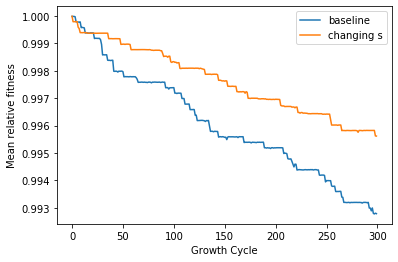

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results.mean(axis=0), label='baseline')
#plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results.mean(axis=0), label='changing mu')
plt.plot(np.arange(nGrowthCyc), sel_parts_experiment_results.mean(axis=0), label='changing s')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')
plt.legend()

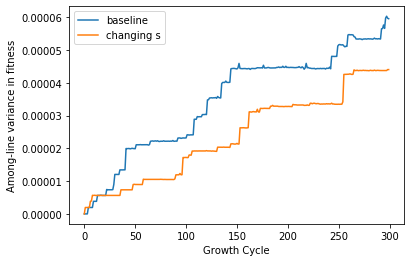

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results.std(axis=0)**2, label='baseline')
#plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results.std(axis=0)**2, label='changing mu')
plt.plot(np.arange(nGrowthCyc), sel_parts_experiment_results.std(axis=0)**2, label='changing s')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')
plt.legend()

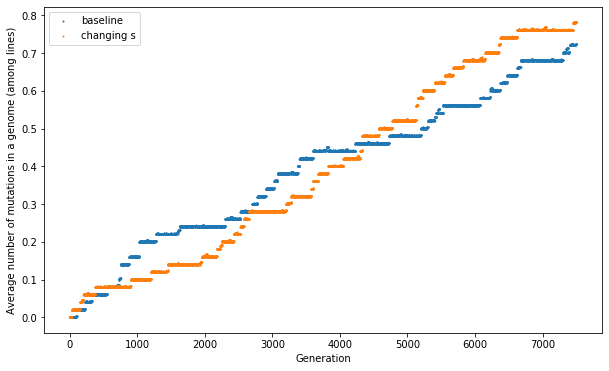

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
#plt.errorbar(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), 
#             yerr=sel_parts_average_muts.std(axis=0)**2, alpha=0.5, marker='s', ms=2, elinewidth=0.1)
plt.scatter(x=np.arange(average_muts.shape[1]), y=average_muts.mean(axis=0), s=1, label='baseline')
plt.scatter(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), 
            s=1, label='changing s')
#plt.scatter(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), s=1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations in a genome (among lines)')
plt.legend()

## Heterogeneity in mutation rates

In [11]:
sns.set(font_scale=1.4, style="whitegrid")

In [16]:
#different mus with stable s
mu1 = 0.001
mu2 = 0.0001
s = 0.1

experiment_results_mu1 = np.load(f'data/baseline_experiment_mu_{mu1}_s_{s}.npy')
average_muts_mu1 = np.load(f'data/baseline_experiment_mut_counts_mu_{mu1}_s_{s}.npy')
experiment_results_mu2 = np.load(f'data/baseline_experiment_mu_{mu2}_s_{s}.npy')
average_muts_mu2 = np.load(f'data/baseline_experiment_mut_counts_mu_{mu2}_s_{s}.npy')

mut_parts_experiment_results = np.load(f'data/different_mus_experiment_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
mut_parts_average_muts = np.load(f'data/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
average_muts_part1 = np.load(f'data/different_mus_experiment_mut_counts_part1_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
average_muts_part2 = np.load(f'data/different_mus_experiment_mut_counts_part2_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
#sel_parts_experiment_results = np.load(f'data/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}.npy')
#sel_parts_average_muts = np.load(f'data/different_s_experiment_mut_counts_s1_{s1}_s2_{s2}_mu_{mu}.npy')
#average_muts_part1_s1 = np.load(f'data/different_s_experiment_mut_counts_part1_s1_{s1}_s2_{s2}_mu_{mu}.npy')
#average_muts_part2_s2 = np.load(f'data/different_s_experiment_mut_counts_part2_s1_{s1}_s2_{s2}_mu_{mu}.npy')

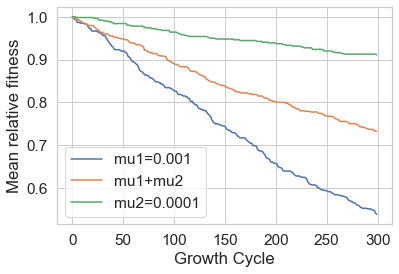

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results_mu1.mean(axis=0), label=f'mu1={mu1}')
plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results.mean(axis=0), label='mu1+mu2')
plt.plot(np.arange(nGrowthCyc), experiment_results_mu2.mean(axis=0), label=f'mu2={mu2}')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')
plt.legend()
#plt.savefig(f'pictures/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}_mean_fitness.png',  
#            bbox_inches='tight', format='png')
plt.show()

In [20]:
R = calculate_regression_coefficient(np.arange(nGrowthCyc), experiment_results_mu2.mean(axis=0))
R

array([-0.00030608])

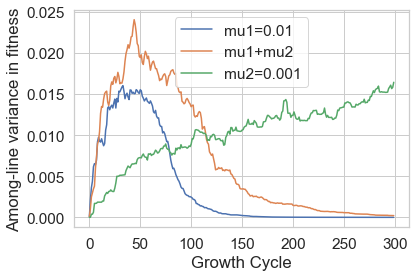

In [75]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results_mu1.std(axis=0)**2, label=f'mu1={mu1}')
plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results.std(axis=0)**2, label='mu1+mu2')
plt.plot(np.arange(nGrowthCyc), experiment_results_mu2.std(axis=0)**2, label=f'mu2={mu2}')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')
plt.legend()
plt.savefig(f'pictures/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}_fitness_std.png',  
            bbox_inches='tight', format='png')
plt.show()

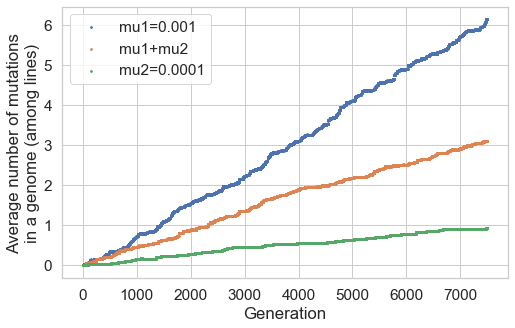

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
#plt.errorbar(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), 
#             yerr=sel_parts_average_muts.std(axis=0)**2, alpha=0.5, marker='s', ms=2, elinewidth=0.1)
plt.scatter(x=np.arange(average_muts_mu1.shape[1]), y=average_muts_mu1.mean(axis=0), s=3, label=f'mu1={mu1}')
plt.scatter(x=np.arange(mut_parts_average_muts.shape[1]), y=mut_parts_average_muts.mean(axis=0), 
            s=3, label='mu1+mu2')
plt.scatter(x=np.arange(average_muts_mu2.shape[1]), y=average_muts_mu2.mean(axis=0), s=3, label=f'mu2={mu2}')
#plt.scatter(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), s=1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations\nin a genome (among lines)')
plt.legend()
#plt.savefig(f'pictures/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}_average_mut.png',  
#            bbox_inches='tight', format='png')
plt.show()

In [23]:
calculate_regression_coefficient(np.arange(nGrowthCyc*25), mut_parts_average_muts.mean(axis=0))

array([0.00041688])

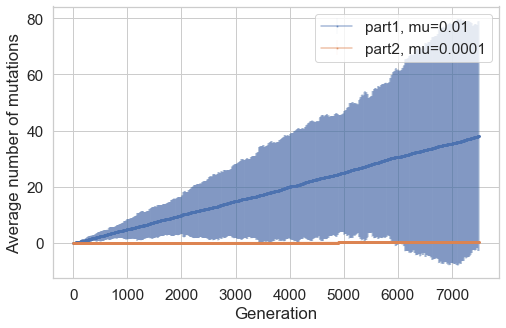

In [176]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.errorbar(x=np.arange(average_muts_part1.shape[1]), y=average_muts_part1.mean(axis=0), 
             yerr=average_muts_part1.std(axis=0)**2, alpha=0.5, marker='s', 
             ms=1, elinewidth=0.1, label=f'part1, mu={mu1}')
plt.errorbar(x=np.arange(average_muts_part2.shape[1]), y=average_muts_part2.mean(axis=0), 
             yerr=average_muts_part2.std(axis=0)**2, alpha=0.5, marker='s', 
             ms=1, elinewidth=0.1, label=f'part2, mu={mu2}')
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations')
plt.legend()
plt.savefig(f'pictures/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}_2_parts.png',  
            bbox_inches='tight', format='png')
plt.show()

## Heterogeneity in selection

In [33]:
#different s with stable mu
mu = 0.0001
s1 = 0.1
s2 = 0.01

experiment_results_s1 = np.load(f'data/baseline_experiment_mu_{mu}_s_{s1}.npy')
average_muts_s1 = np.load(f'data/baseline_experiment_mut_counts_mu_{mu}_s_{s1}.npy')
experiment_results_s2 = np.load(f'data/baseline_experiment_mu_{mu}_s_{s2}.npy')
average_muts_s2 = np.load(f'data/baseline_experiment_mut_counts_mu_{mu}_s_{s2}.npy')

#mut_parts_experiment_results = np.load(f'data/different_mus_experiment_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
#mut_parts_average_muts = np.load(f'data/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
#average_muts_part1 = np.load(f'data/different_mus_experiment_mut_counts_part1_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
#average_muts_part2 = np.load(f'data/different_mus_experiment_mut_counts_part2_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
sel_parts_experiment_results = np.load(f'data/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}.npy')
sel_parts_average_muts = np.load(f'data/different_s_experiment_mut_counts_s1_{s1}_s2_{s2}_mu_{mu}.npy')
average_muts_part1_s1 = np.load(f'data/different_s_experiment_mut_counts_part1_s1_{s1}_s2_{s2}_mu_{mu}.npy')
average_muts_part2_s2 = np.load(f'data/different_s_experiment_mut_counts_part2_s1_{s1}_s2_{s2}_mu_{mu}.npy')

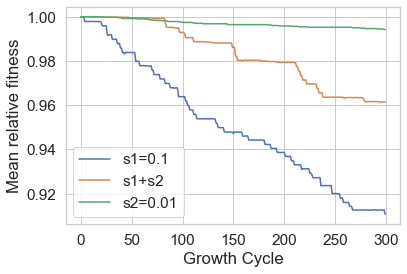

In [34]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results_s1.mean(axis=0), label=f's1={s1}')
plt.plot(np.arange(nGrowthCyc), sel_parts_experiment_results.mean(axis=0), label='s1+s2')
plt.plot(np.arange(nGrowthCyc), experiment_results_s2.mean(axis=0), label=f's2={s2}')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')
plt.savefig(f'pictures/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}_mean_fitness.png',  
            bbox_inches='tight', format='png')
plt.legend()
#plt.savefig(f'pictures/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}_mean_fitness.png',  
#            bbox_inches='tight', format='png')
plt.show()

In [37]:
R = calculate_regression_coefficient(np.arange(nGrowthCyc), experiment_results_s1.mean(axis=0))
R

array([-0.00030608])

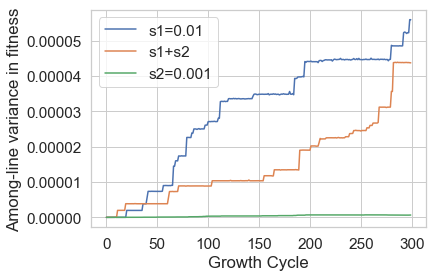

In [122]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), experiment_results_s1.std(axis=0)**2, label=f's1={s1}')
plt.plot(np.arange(nGrowthCyc), sel_parts_experiment_results.std(axis=0)**2, label='s1+s2')
plt.plot(np.arange(nGrowthCyc), experiment_results_s2.std(axis=0)**2, label=f's2={s2}')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')
plt.legend()
plt.savefig(f'pictures/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}_fitness_std.png',  
            bbox_inches='tight', format='png')
plt.show()

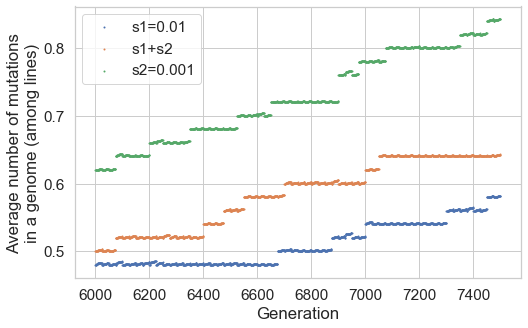

In [123]:
fig, ax = plt.subplots(figsize=(8, 5))
#plt.errorbar(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), 
#             yerr=sel_parts_average_muts.std(axis=0)**2, alpha=0.5, marker='s', ms=2, elinewidth=0.1)
plt.scatter(x=np.arange(average_muts_s1.shape[1])[6000:], y=average_muts_s1.mean(axis=0)[6000:], s=1, 
            label=f's1={s1}')
plt.scatter(x=np.arange(sel_parts_average_muts.shape[1])[6000:], y=sel_parts_average_muts.mean(axis=0)[6000:], 
            s=1, label='s1+s2')
plt.scatter(x=np.arange(average_muts_s2.shape[1])[6000:], y=average_muts_s2.mean(axis=0)[6000:], s=1, 
            label=f's2={s2}')
#plt.scatter(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), s=1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations\nin a genome (among lines)')
plt.legend()
plt.savefig(f'pictures/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}_average_mut_zoomed.png',  
            bbox_inches='tight', format='png')
plt.show()

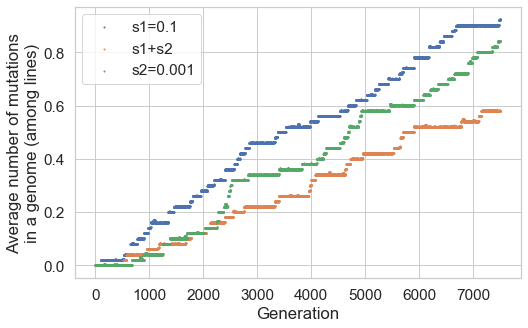

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
#plt.errorbar(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), 
#             yerr=sel_parts_average_muts.std(axis=0)**2, alpha=0.5, marker='s', ms=2, elinewidth=0.1)
plt.scatter(x=np.arange(average_muts_s1.shape[1]), y=average_muts_s1.mean(axis=0), s=1, 
            label=f's1={s1}')
plt.scatter(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), 
            s=1, label='s1+s2')
plt.scatter(x=np.arange(average_muts_s2.shape[1]), y=average_muts_s2.mean(axis=0), s=1, label=f's2={s2}')
#plt.scatter(x=np.arange(sel_parts_average_muts.shape[1]), y=sel_parts_average_muts.mean(axis=0), s=1)
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations\nin a genome (among lines)')
plt.legend()
#plt.savefig(f'pictures/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}_average_mut.png',  
#            bbox_inches='tight', format='png')
plt.show()

In [38]:
calculate_regression_coefficient(np.arange(nGrowthCyc*25), sel_parts_average_muts.mean(axis=0))

array([0.00011599])

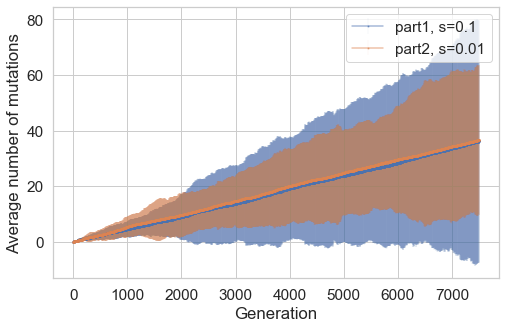

In [199]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.errorbar(x=np.arange(average_muts_part1_s1.shape[1]), y=average_muts_part1_s1.mean(axis=0), 
             yerr=average_muts_part1_s1.std(axis=0)**2, alpha=0.5, marker='s', 
             ms=1, elinewidth=0.1, label=f'part1, s={s1}')
plt.errorbar(x=np.arange(average_muts_part2_s2.shape[1]), y=average_muts_part2_s2.mean(axis=0), 
             yerr=average_muts_part2_s2.std(axis=0)**2, alpha=0.5, marker='s', 
             ms=1, elinewidth=0.1, label=f'part2, s={s2}')
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations')
plt.legend()
plt.savefig(f'pictures/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}_2_parts.png',  
            bbox_inches='tight', format='png')
plt.show()

# Different mutation rate and selection coefficient simultaneously

In [50]:
mu1 = 0.001
mu2 = 0.0001
s1 = 0.01
s2 = 0.001

#experiment_results_s1 = np.load(f'data/baseline_experiment_mu_{mu}_s_{s1}.npy')
#average_muts_s1 = np.load(f'data/baseline_experiment_mut_counts_mu_{mu}_s_{s1}.npy')
#experiment_results_s2 = np.load(f'data/baseline_experiment_mu_{mu}_s_{s2}.npy')
#average_muts_s2 = np.load(f'data/baseline_experiment_mut_counts_mu_{mu}_s_{s2}.npy')

experiment_results = np.load(f'data/new/fitness_mu1_{mu1}_mu2_{mu2}_s1_{s1}_s2_{s2}.npy')
#mut_parts_average_muts = np.load(f'data/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s}.npy')
average_muts_part1 = np.load(f'data/new/mut_counts_part1_mu1_{mu1}_mu2_{mu2}_s1_{s1}_s2_{s2}.npy')
average_muts_part2 = np.load(f'data/new/mut_counts_part2_mu1_{mu1}_mu2_{mu2}_s1_{s1}_s2_{s2}.npy')

average_muts_part1_s1 = np.load(f'data/different_mus_experiment_mut_counts_part1_mu1_{mu1}_mu2_{mu2}_s_{s1}.npy')
average_muts_part2_s1 = np.load(f'data/different_mus_experiment_mut_counts_part2_mu1_{mu1}_mu2_{mu2}_s_{s1}.npy')
average_muts_part1_s2 = np.load(f'data/different_mus_experiment_mut_counts_part1_mu1_{mu1}_mu2_{mu2}_s_{s2}.npy')
average_muts_part2_s2 = np.load(f'data/different_mus_experiment_mut_counts_part2_mu1_{mu1}_mu2_{mu2}_s_{s2}.npy')

mut_parts_experiment_results_s1 = np.load(f'data/different_mus_experiment_mu1_{mu1}_mu2_{mu2}_s_{s1}.npy')
mut_parts_experiment_results_s2 = np.load(f'data/different_mus_experiment_mu1_{mu1}_mu2_{mu2}_s_{s2}.npy')
mut_parts_average_muts = np.load(f'data/different_mus_experiment_mut_counts_mu1_{mu1}_mu2_{mu2}_s_{s1}.npy')

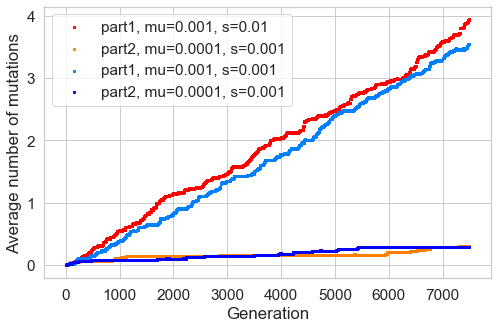

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
#plt.errorbar(x=np.arange(average_muts_part1_s1.shape[1]), y=average_muts_part1_s1.mean(axis=0), 
#             yerr=average_muts_part1_s1.std(axis=0)**2, alpha=0.5, marker='s', 
#             ms=1, elinewidth=0.1, label=f'part1, s={s1}')
#plt.errorbar(x=np.arange(average_muts_part2_s2.shape[1]), y=average_muts_part2_s2.mean(axis=0), 
#             yerr=average_muts_part2_s2.std(axis=0)**2, alpha=0.5, marker='s', 
#             ms=1, elinewidth=0.1, label=f'part2, s={s2}')

plt.scatter(x=np.arange(average_muts_part1.shape[1]), y=average_muts_part1.mean(axis=0), 
             alpha=0.9, marker='s', 
             s=5, label=f'part1, mu={mu1}, s={s1}', color='#ff0000')
plt.scatter(x=np.arange(average_muts_part2.shape[1]), y=average_muts_part2.mean(axis=0), 
             alpha=0.9, marker='s', 
             s=5, label=f'part2, mu={mu2}, s={s2}', color='#ff8000')


plt.scatter(x=np.arange(average_muts_part1_s2.shape[1]), y=average_muts_part1_s2.mean(axis=0), 
             alpha=0.9, marker='s', 
             s=5, label=f'part1, mu={mu1}, s={s2}', color='#0080FF')
plt.scatter(x=np.arange(average_muts_part2_s2.shape[1]), y=average_muts_part2_s2.mean(axis=0), 
             alpha=0.9, marker='s', 
             s=5, label=f'part2, mu={mu2}, s={s2}', color='#0000FF')
ax.set_xlabel('Generation')
ax.set_ylabel('Average number of mutations')
plt.legend()
plt.savefig(f'pictures/new/mixed_model_2.png',  
            bbox_inches='tight', format='png')
plt.show()

In [39]:
nGrowthCyc = 300

In [52]:
experiment_results.shape

(50, 300)

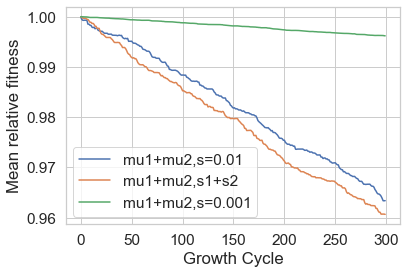

In [54]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results_s1.mean(axis=0), label=f'mu1+mu2,s={s1}')
plt.plot(np.arange(nGrowthCyc), experiment_results.mean(axis=0), label='mu1+mu2,s1+s2')
plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results_s2.mean(axis=0), label=f'mu1+mu2,s={s2}')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Mean relative fitness')
#plt.savefig(f'pictures/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}_mean_fitness.png',  
#            bbox_inches='tight', format='png')
plt.legend()
plt.savefig(f'pictures/new/mixed_model_mean_fitness.png',  
            bbox_inches='tight', format='png')
plt.show()

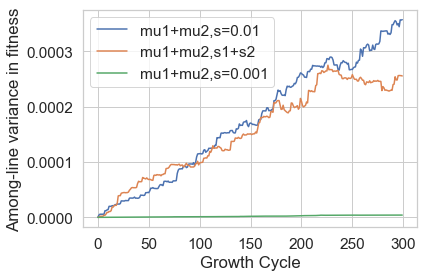

In [55]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results_s1.std(axis=0)**2, label=f'mu1+mu2,s={s1}')
plt.plot(np.arange(nGrowthCyc), experiment_results.std(axis=0)**2, label='mu1+mu2,s1+s2')
plt.plot(np.arange(nGrowthCyc), mut_parts_experiment_results_s2.std(axis=0)**2, label=f'mu1+mu2,s={s2}')
ax.set_xlabel('Growth Cycle')
ax.set_ylabel('Among-line variance in fitness')
#plt.savefig(f'pictures/different_s_experiment_s1_{s1}_s2_{s2}_mu_{mu}_mean_fitness.png',  
#            bbox_inches='tight', format='png')
plt.legend()
plt.savefig(f'pictures/new/mixed_model_fitness_std.png',  
            bbox_inches='tight', format='png')
plt.show()

# References

1. The Lower Bound to the Evolution of Mutation Rates (https://doi.org/10.1093/gbe/evr066). Paper with population simulations described in details
2. Genetic drift, selection and the evolution of the mutation rate. https://www.nature.com/articles/nrg.2016.104. Main paper, the review about mutation rate evolution
3. https://github.com/SasankYadati/wright-fisher-population-genetics-simulation - github with Wright-Fisher simple model, this code is partially based on it.
4. Estimate of the genomic mutation rate deleterious to overall fitness in E. coli. https://www.nature.com/articles/381694a0. The paper with mutation accumulation experiment description.
5. https://www.pnas.org/doi/pdf/10.1073/pnas.96.20.11393